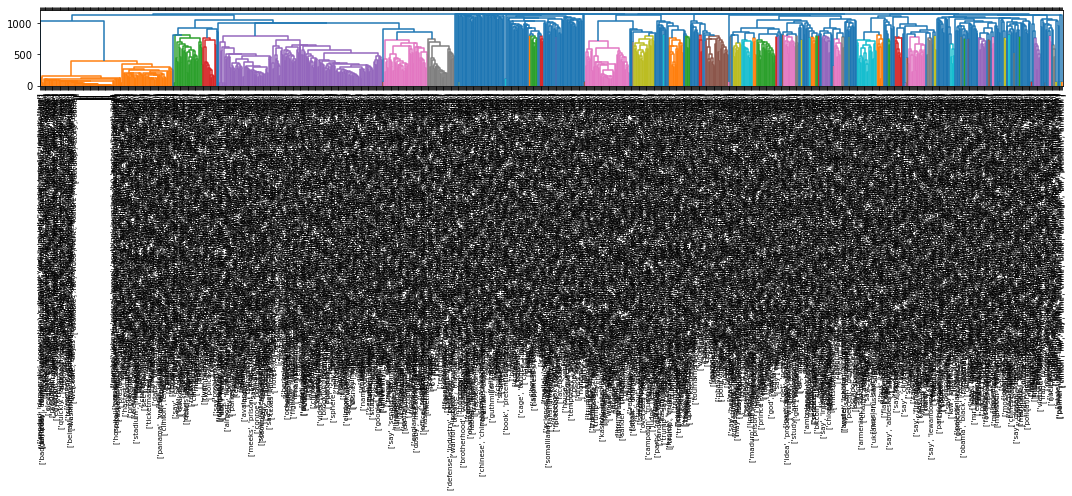

In [1]:
import os
import nltk
import unicodedata
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from nltk.corpus import wordnet as wn
from sklearn.cluster import AgglomerativeClustering

# from corpus import HTMLPickledCorpusReader
# from reader import HTMLPickledCorpusReader

ROOT = 'os.getcwd()'
# small sample corpus of 40 news items for illustration purposes
CORPUS = os.path.join(ROOT, "fixtures", "sample")

STOPWORDS = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()


def is_punct(token):
    # Is every character punctuation?
    return all(
        unicodedata.category(char).startswith('P')
        for char in token
    )


def wnpos(tag):
    # Return the WordNet POS tag from the Penn Treebank tag
    return {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)


def normalize(document, stopwords=STOPWORDS):
    """
    Removes stopwords and punctuation, lowercases, lemmatizes
    """

    for token, tag in document:
        token = token.lower().strip()

        if is_punct(token) or (token in stopwords):
            continue

        yield lemmatizer.lemmatize(token, wnpos(tag))


class HierarchicalTopics(object):

    def __init__(self, corpus):
        """
        corpus is a corpus object, e.g. an HTMLCorpusReader()
        or an HTMLPickledCorpusReader() object
        """
        self.model = None
        self.vocab = list(
            set(normalize(corpus.words(categories=['news'])))
        )

    def vectorize(self, document):
        """
        Vectorizes a document consisting of a list of part of speech
        tagged tokens using the segmentation and tokenization methods.
        One-hot encode the set of documents
        """
        features = set(normalize(document))
        return np.array([
            token in features for token in self.vocab], np.short)

    def cluster(self, corpus):
        """
        Fits the AgglomerativeClustering model to the given data.
        """
        self.model = AgglomerativeClustering()

        self.model.fit_predict([
            self.vectorize(
                corpus.words(fileid)) for fileid in
            corpus.fileids(categories=['news']
                           )
        ])

        self.labels = self.model.labels_
        self.children = self.model.children_

    def plot_dendrogram(self, **kwargs):
        # Distances between each pair of children
        distance = np.arange(self.children.shape[0])
        position = np.arange(self.children.shape[0])

        # Create linkage matrix and then plot the dendrogram
        linkage_matrix = np.column_stack([
            self.children, distance, position]
        ).astype(float)

        # Plot the corresponding dendrogram
        fig, ax = plt.subplots(figsize=(15, 7))  # set size
        ax = dendrogram(linkage_matrix, **kwargs)
        plt.tick_params(axis='x', bottom='off', top='off', labelbottom='off')
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    from collections import Counter
    from reader import PickledCorpusReader  

#     corpus = HTMLPickledCorpusReader(CORPUS)
    corpus = PickledCorpusReader('../ATAwP/corpus')

    labels = []
    for fileid in corpus.fileids(categories=['news']):
        terms = []
        for term, count in Counter(list(normalize(corpus.words(fileid)))).most_common(10):
            terms.append(term)
        labels.append(terms)

    clusterer = HierarchicalTopics(corpus)
    clusterer.cluster(corpus)
    # for idx, fileid in enumerate(corpus.fileids(categories=['news'])):
    #     print(clusterer.labels[idx], fileid)

    clusterer.plot_dendrogram(labels=labels, leaf_font_size=7)